# Model building

## Imports

In [2]:
import requests
import zipfile
import os
import pandas as pd
import ftplib
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from joblib import dump, load
from pathlib import Path

## Get data for the model

In [3]:
# load the merged and preprocessed data
data = pd.read_csv('data/preprocessed_data.csv')

## Simple model: Linear regression

In [4]:
# Target variable
y = data.SOG_norm

# Predictors
features = ['VHM0_norm','VMDR_norm', 'VTPK_norm', 'Temperature_norm','Salinity_norm', 'Thickness_norm'] 
X = data[features]

# Split data to train and validation
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

In [5]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(train_X, train_y)

# Make predictions using the testing set
pred_y = regr.predict(val_X)

# The coefficients
print('Coefficients: \n', regr.coef_)

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(val_y, pred_y))
      
print('R^2: %.2f'
      % r2_score(val_y, pred_y))

Coefficients: 
 [0.09789246 0.02740957 0.0742894  0.14307844 0.06053226 0.02093163]
Mean squared error: 0.03
R^2: 0.05


## Intermediate model: Random forest

In [6]:
my_file = Path('data/rf_model.joblib')

if my_file.is_file():
    forest_model = load('data/rf_model.joblib') 

else:
    forest_model = RandomForestRegressor(random_state = 1)
    forest_model.fit(train_X, train_y)
    pred_y = forest_model.predict(val_X)

    print('Mean squared error: %.2f'
          % mean_squared_error(val_y, pred_y))

    print('R^2: %.2f'
          % r2_score(val_y, pred_y))

    dump(forest_model, 'data/rf_model.joblib') 

# Add variable importance
feature_importance_values = forest_model.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

R^2 of Random forest: 0.89

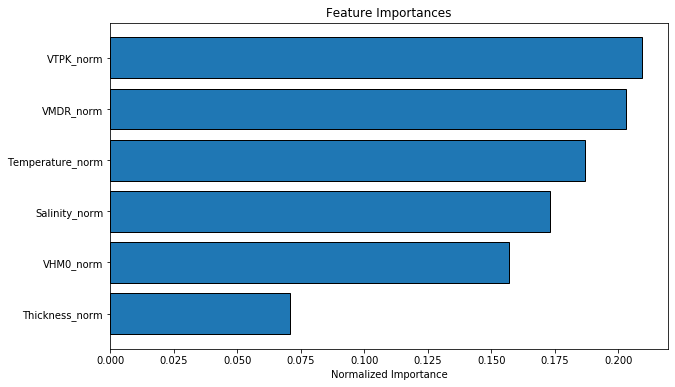

In [7]:
def plot_feature_importances(df):
    
    """Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called 'importance'
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

# Routing

## Get forecast data for the routing

- 2021-06-01
- 2021-06-02
- 2021-06-03

In [8]:
wav_all = xr.open_mfdataset('data/routing/mf*.nc')
phy_all = xr.open_mfdataset('data/routing/me*.nc')

## Area of interest

Calculate the optimal shipping route between Lisbon and Rio de Janeiro considering wave and weather forecasts.

Lisbon: 38.716666° N 9.1667° W

Rio de Janeiro: 22.908333° S 43.196389° W

In [9]:
# Get array index to the value that is closest to a given value
def get_closest(array, value):
    return np.abs(array - value).argmin()

In [10]:
# Set bounding box for the allowed routing corridor
bbox = ((-45, -25),(-7, 41))

In [11]:
# Get indices of the bbox
lon_min = get_closest(wav_all.longitude.data, bbox[0][0])
lat_min = get_closest(wav_all.latitude.data, bbox[0][1])
lon_max = get_closest(wav_all.longitude.data, bbox[1][0])
lat_max = get_closest(wav_all.latitude.data, bbox[1][1])

## Simple solution: Calculate optimal route with weights for one day

- 2021-06-01

In [12]:
# Define first common time (12:00:00)
time_slice_wav = 3
time_slice_phy = 0
# Extract array from dataset to define the cost in the routing algorithm 
# Wave height
wave_height = wav_all.VHM0.isel(time=time_slice_wav, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max))

# Wave direction
wave_dir = wav_all.VMDR.isel(time=time_slice_wav, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max))

# Wave period
wave_per = wav_all.VTPK.isel(time=time_slice_wav, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max))

# Temperature
temp = phy_all.thetao.isel(time=time_slice_phy, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max), depth = 0)

# Salinity
sal = phy_all.so.isel(time=time_slice_phy, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max), depth = 0)

# Thickness
thi = phy_all.mlotst.isel(time=time_slice_phy, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max))

### Start and end point of the route

In [13]:
lat_Lis = 38.716666
lon_Lis = -9.1667
lat_Rio = -22.908333
lon_Rio = -43.196389

In [14]:
start_lon = get_closest(wave_height.longitude.data, lon_Lis)
start_lat = get_closest(wave_height.latitude.data, lat_Lis)
end_lon = get_closest(wave_height.longitude.data,lon_Rio)
end_lat = get_closest(wave_height.latitude.data,lat_Rio)

In [15]:
start = (start_lat, start_lon)
end = (end_lat, end_lon)

In [16]:
# Mask land areas
land_mask = wave_height.data
land_mask[np.isnan(land_mask)] = 1

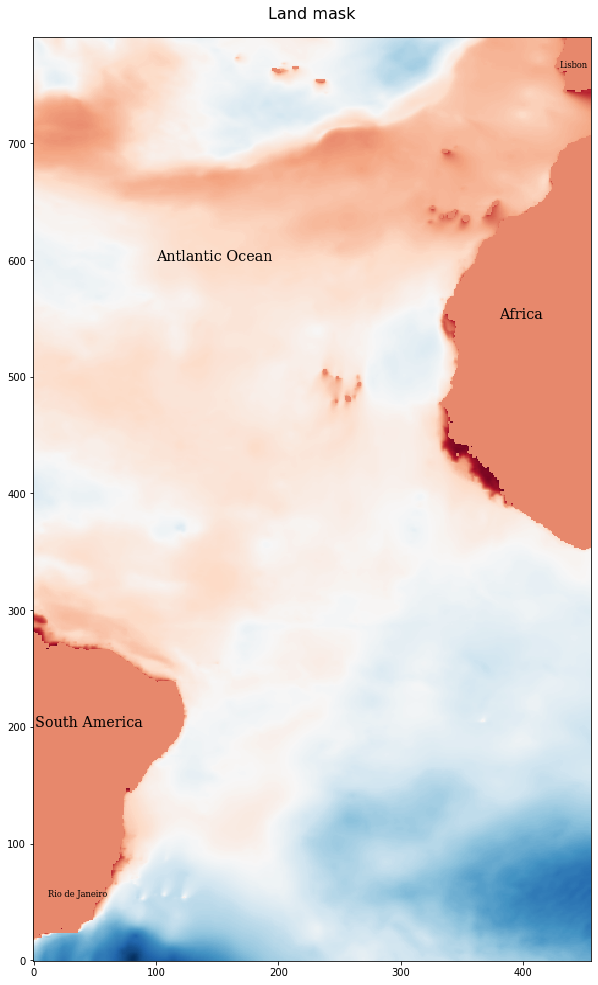

In [17]:
# Plot optimal route
plt.figure(figsize=(10,17))

plt.imshow(land_mask, aspect='auto', cmap = 'RdBu')
plt.text(start[1],start[0], 'Lisbon', color = 'black', fontfamily = 'serif', fontsize = 'small')
plt.text(end[1]-10,end[0]+30, 'Rio de Janeiro', color = 'black', fontfamily = 'serif', fontsize = 'small')
plt.text(100, 600, 'Antlantic Ocean', color = 'black', fontfamily = 'serif', fontsize = 'x-large')
plt.text(1, 200, 'South America', color = 'black', fontfamily = 'serif', fontsize = 'x-large')
plt.text(380, 550, 'Africa', color = 'black', fontfamily = 'serif', fontsize = 'x-large')
plt.title('Land mask', fontsize = 16, pad = 18)
plt.gca().invert_yaxis()

### Get variable costs

In [18]:
# Assign data directly as costs
wh_costs = wave_height.data
wd_costs = wave_dir.data
wp_costs = wave_per.data
temp_costs = temp.data
sal_costs = sal.data
thi_costs = thi.data

In [19]:
np.sum(np.isnan(wd_costs)).compute()

50735

In [20]:
# Set NaN values to large wh_costs as the algorithm cannot handle NaNs
# wh_costs[np.isnan(wh_costs)] = np.nanmean(wh_costs) 
# wd_costs[np.isnan(wd_costs)] = np.nanmean(wd_costs) 
# wp_costs[np.isnan(wp_costs)] = np.nanmean(wp_costs) 
# temp_costs[np.isnan(temp_costs)] = np.nanmean(temp_costs) 
# sal_costs[np.isnan(sal_costs)] = np.nanmean(sal_costs)
# thi_costs[np.isnan(thi_costs)] = np.nanmean(thi_costs) 

In [21]:
def stand_and_norm (x): 
    # Standardization
    x_stand = (x - np.nanmean(x)) / np.nanstd(x)

    # Normalization
    x_norm = (x_stand - np.nanmin(x_stand)) / (np.nanmax(x_stand) - np.nanmin(x_stand))

    # Check for na values and assign them with maximum values
    if(np.any(np.isnan(x_norm))):
        x_norm[np.isnan(x_norm)] = 1 # np.nanmax(x_norm)
    #else:
     #   x_norm[land_mask == 1] = np.max(x_norm)
    
    return x_norm

In [22]:
wh_costs = stand_and_norm(wh_costs)
wd_costs = stand_and_norm(wd_costs)
wp_costs = stand_and_norm(wp_costs)
temp_costs = stand_and_norm(temp_costs)
sal_costs = stand_and_norm(sal_costs)
thi_costs = stand_and_norm(thi_costs)

### Calulate costs based on linear regression model

In [23]:
# wh_costs[np.isnan(wh_costs)] = np.nanmax(wh_costs)
# wd_costs[np.isnan(wd_costs)] = np.nanmax(wd_costs)
# wp_costs[np.isnan(wp_costs)] = np.nanmax(wp_costs)
# temp_costs[np.isnan(temp_costs)] = np.nanmax(temp_costs)
# sal_costs[np.isnan(sal_costs)] = np.nanmax(sal_costs)
# thi_costs[np.isnan(thi_costs)] = np.nanmax(thi_costs)

In [24]:
#wh_costs[land_mask == 1] = wh_costs.max()
#wd_costs[land_mask == 1] = wd_costs.max()
#wp_costs[land_mask == 1] = wp_costs.max()
#temp_costs[land_mask == 1] = temp_costs.max()
#sal_costs[land_mask == 1] = sal_costs.max()
#thi_costs[land_mask == 1] = thi_costs.max()

In [25]:
# Get regression coefficients
rc = regr.coef_

# Weight are taken from linear regression model
speed = rc[0]*wh_costs + rc[1]*wd_costs + rc[2]*wp_costs + rc[3]*temp_costs + rc[4]*sal_costs + rc[5]*thi_costs

# invert costs, because costs imitate speed 
inverted_speed = -1*speed + np.abs(np.max(speed))

In [26]:
wh_costs[land_mask == 1] = 1
inverted_speed[land_mask == 1] = 1

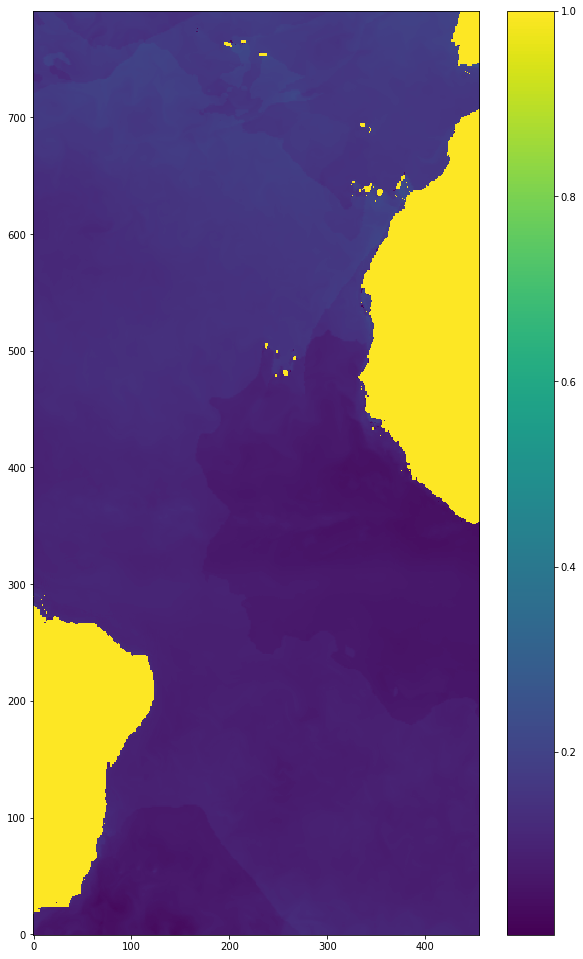

In [27]:
# Plot optimal route
plt.figure(figsize=(10,17))

# Costs
plt.imshow(inverted_speed, aspect='auto', vmin=np.min(inverted_speed), vmax=np.max(inverted_speed))

plt.colorbar()

plt.gca().invert_yaxis()

In [28]:
inverted_speed = inverted_speed.compute()

In [29]:
from skimage.graph import route_through_array

# Calculate optimal route based on the minimum cost path

# Optional parameters:
# - fully_connected 
#     - False -> only axial moves are allowed
#     - True  -> diagonal moves are allowed
# - geometric 
#     - False -> minimum cost path
#     - True  -> distance-weighted minimum cost path

wh_indices, weight = route_through_array(wh_costs, start, end, fully_connected=True, geometric=True)
wh_indices = np.stack(wh_indices, axis=-1)

wd_indices, weight = route_through_array(wd_costs, start, end, fully_connected=True, geometric=True)
wd_indices = np.stack(wd_indices, axis=-1)

wp_indices, weight = route_through_array(wp_costs, start, end, fully_connected=True, geometric=True)
wp_indices = np.stack(wp_indices, axis=-1)

temp_indices, weight = route_through_array(temp_costs, start, end, fully_connected=True, geometric=True)
temp_indices = np.stack(temp_indices, axis=-1)

sal_indices, weight = route_through_array(sal_costs, start, end, fully_connected=True, geometric=True)
sal_indices = np.stack(sal_indices, axis=-1)

thi_indices, weight = route_through_array(thi_costs, start, end, fully_connected=True, geometric=True)
thi_indices = np.stack(thi_indices, axis=-1)

merged_indices, weight_lr = route_through_array(inverted_speed, start, end, fully_connected=True, geometric=True)
merged_indices = np.stack(merged_indices, axis=-1)

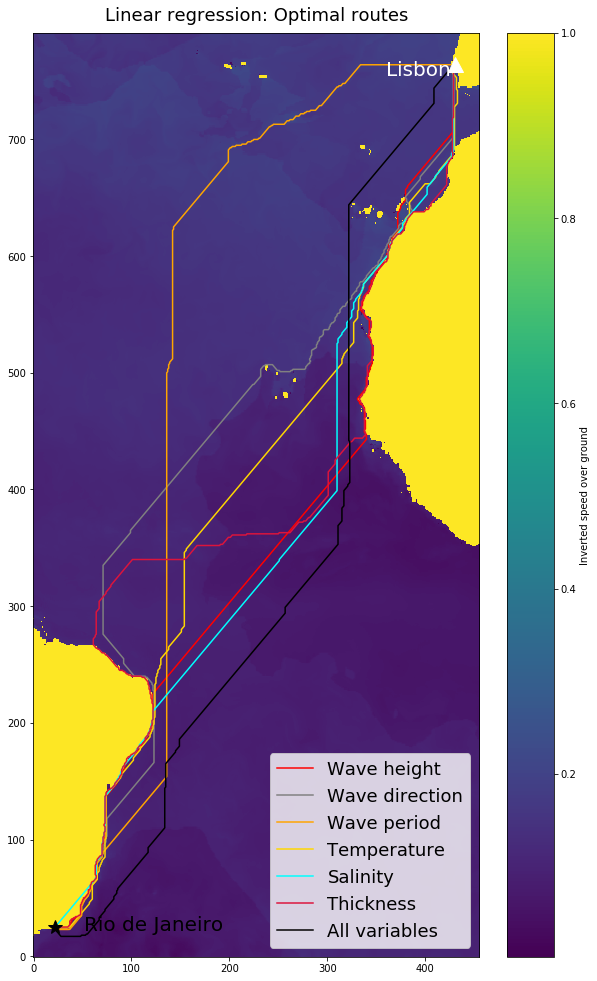

In [30]:
# Plot optimal route
plt.figure(figsize=(10,17))

# Costs
plt.imshow(inverted_speed, aspect='auto', vmin=np.min(inverted_speed), vmax=np.max(inverted_speed))

# Routes
plt.plot(wh_indices[1], wh_indices[0], 'red', label = 'Wave height')
plt.plot(wd_indices[1], wd_indices[0], 'grey', label = 'Wave direction')
plt.plot(wp_indices[1], wp_indices[0], 'orange', label = 'Wave period')
plt.plot(temp_indices[1], temp_indices[0], 'gold', label = 'Temperature')
plt.plot(sal_indices[1], sal_indices[0], 'cyan', label = 'Salinity')
plt.plot(thi_indices[1], thi_indices[0], 'crimson', label = 'Thickness')
plt.plot(merged_indices[1], merged_indices[0], 'black', label = 'All variables')

# Start/end points
plt.plot(start_lon, start_lat, 'k^', markersize = 15, color = 'white')
plt.text(start_lon - 70, start_lat - 10, 'Lisbon', fontsize = 20, color = 'white')
plt.plot(end_lon, end_lat, 'k*', markersize = 15)
plt.text(end_lon + 30, end_lat - 3, 'Rio de Janeiro', fontsize = 20)
plt.title('Linear regression: Optimal routes', fontsize = 18, pad = 12)
plt.colorbar(label='Inverted speed over ground')
plt.legend(loc = "lower right", prop={'size': 18})
plt.gca().invert_yaxis()

### Calulate costs based on random forest model

In [31]:
# Reshape 2d array to dataframes to apply the random forest
wave_height_1d = pd.DataFrame(data = wh_costs.compute().ravel())
wave_dir_1d = pd.DataFrame(data = wd_costs.compute().ravel())
wave_per_1d = pd.DataFrame(data = wp_costs.compute().ravel())
temp_1d = pd.DataFrame(data = temp_costs.compute().ravel())
sal_1d = pd.DataFrame(data = sal_costs.compute().ravel())
thi_1d = pd.DataFrame(data = thi_costs.compute().ravel())

concat_costs = pd.concat([wave_height_1d, wave_dir_1d, wave_per_1d, temp_1d, sal_1d, thi_1d], axis = 1)
concat_costs.columns = ['Wave height', 'Wave direction', 'Wave period', 'Temperature', 'Salinity', 'Thickness']

for_pred = forest_model.predict(concat_costs)

In [32]:
# Invert costs, because costs imitate speed 
inverted_speed_forest = -1 * for_pred + np.abs(np.max(for_pred))

In [33]:
# Reshape speed costs to get back the map
wave_height_np = wh_costs.compute()

map_shape = wave_height_np.shape

rf_speed = np.reshape(inverted_speed_forest, map_shape)

In [34]:
# Assign non-water areas high values
rf_speed[land_mask ==1] = 1 # np.max(rf_speed)

In [35]:
# Compute route
rf_indices, weight_simple_day_one = route_through_array(rf_speed, start, end, fully_connected=True, geometric=True)
rf_indices = np.stack(rf_indices, axis=-1)

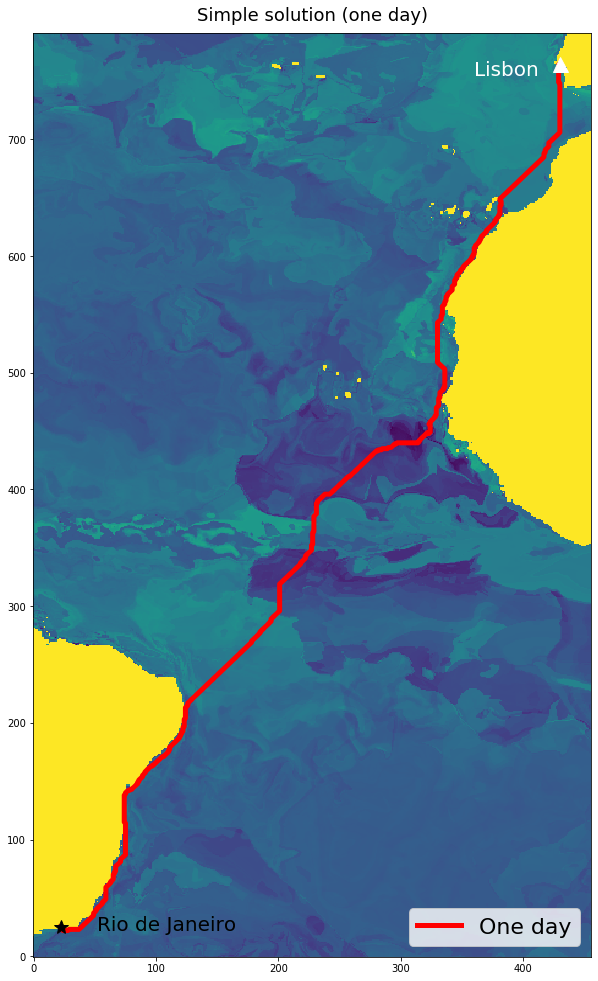

In [36]:
# Presentation plot simple solution
# Plot optimal route
plt.figure(figsize=(10,17))

# Costs
plt.imshow(rf_speed, aspect='auto')

plt.plot(rf_indices[1],rf_indices[0], 'red', label = 'One day', lw = 5)

# Start/end points
plt.plot(start_lon, start_lat, 'k^', markersize = 15, color = 'white')
plt.text(start_lon - 70, start_lat - 10, 'Lisbon', fontsize = 20, color = 'white')
plt.plot(end_lon, end_lat, 'k*', markersize = 15)
plt.text(end_lon + 30, end_lat - 3, 'Rio de Janeiro', fontsize = 20)
plt.title('Simple solution (one day)', fontsize = 18, pad = 12)
plt.legend(loc = 'lower right', prop={'size': 22})
#plt.colorbar(label='Inverted speed over ground')
plt.gca().invert_yaxis()

## Advanced solution: Calculate optimal route based on *multiple* variables and *multiple* days

In [37]:
# Show times for WAV
time = phy_all.sel(time=~phy_all.get_index('time').duplicated()).time

rows = []

for step in range(time.size):
    
    time_df_phy = str(time.values[step])
    rows.append([step, time_df_phy])

time_df_phy = pd.DataFrame(rows, columns = ['Step', 'Time'])

In [38]:
# Show times for PHY
time = wav_all.sel(time=~wav_all.get_index('time').duplicated()).time

rows = []

for step in range(time.size):
    
    time_df_wav = str(time.values[step])
    rows.append([step, time_df_wav])

time_df_wav = pd.DataFrame(rows, columns = ['Step', 'Time'])

In [39]:
# Get the times that exist in both datasets (12:00:00 for the three days)
common_time = np.intersect1d(time_df_wav['Time'], time_df_phy['Time'])

# Create arrays with the corresponding steps - For waves forecast: [3, 11, 19, 27] & For physics forecast: [0, 1, 2, 3]
time_wav = []
time_phy = []

for t in range(common_time.size):
    time_wav.append(int(time_df_wav['Step'].loc[time_df_wav['Time'] == common_time[t]]))
    time_phy.append(int(time_df_phy['Step'].loc[time_df_phy['Time'] == common_time[t]]))

# Create time slices (start, end, step)
step_wav = time_wav[1] - time_wav[0]
time_slice_wav = slice(min(time_wav), max(time_wav) + 1, step_wav)
step_phy = time_phy[1] - time_phy[0]
time_slice_phy = slice(min(time_phy), max(time_phy) + 1, step_phy)

In [40]:
# Extract array from dataset to define the cost in the routing algorithm with a new time_slice
# Wave height
wave_height_3day = wav_all.VHM0.isel(time=time_slice_wav, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max))

# Wave direction
wave_dir_3day = wav_all.VMDR.isel(time=time_slice_wav, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max))

# Wave period
wave_per_3day = wav_all.VTPK.isel(time=time_slice_wav, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max))

# Temperature
temp_3day = phy_all.thetao.isel(time=time_slice_phy, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max), depth = 0)

# Salinity
sal_3day = phy_all.so.isel(time=time_slice_phy, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max), depth = 0)

# Thickness
thi_3day = phy_all.mlotst.isel(time=time_slice_phy, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max))

In [41]:
wh_costs_3d = wave_height_3day.data.compute()
wd_costs_3d = wave_dir_3day.data.compute()
wp_costs_3d = wave_per_3day.data.compute()
te_costs_3d = temp_3day.data.compute()
sa_costs_3d = sal_3day.data.compute()
th_costs_3d = thi_3day.data.compute()

In [45]:
np.shape(wave_height_3day)

(3, 792, 456)

In [47]:
# standardize each time slice (day)
for i in range (np.shape(wave_height_3day)[0]):
    wh_costs_3d[i] = stand_and_norm(wh_costs_3d[i])
    wd_costs_3d[i] = stand_and_norm(wd_costs_3d[i])
    wp_costs_3d[i] = stand_and_norm(wp_costs_3d[i])
    te_costs_3d[i] = stand_and_norm(te_costs_3d[i])
    sa_costs_3d[i] = stand_and_norm(sa_costs_3d[i])
    th_costs_3d[i] = stand_and_norm(th_costs_3d[i])

In [48]:
# Calculate multidimensional costs
# wh_costs = wave_height
# wh_costs = wh_costs.fillna(np.nanmean(wh_costs))
# wh_costs = stand_and_norm(wh_costs)

# wd_costs = wave_dir
# wd_costs = wd_costs.fillna(np.nanmean(wd_costs))
# wd_costs = stand_and_norm(wd_costs)

# wp_costs = wave_per
# wp_costs = wp_costs.fillna(np.nanmean(wp_costs))
# wp_costs = stand_and_norm(wp_costs)

# temp_costs = temp
# temp_costs = temp_costs.fillna(np.nanmean(temp_costs))
# temp_costs = temp_costs.reindex(latitude = wh_costs.latitude, method = 'nearest', tolerance = 123).reindex(longitude = wh_costs.longitude, method='nearest', tolerance = 123)
# temp_costs = stand_and_norm(temp_costs)

# sal_costs = sal
# sal_costs = sal_costs.fillna(np.nanmean(sal_costs))
# sal_costs = sal_costs.reindex(latitude = wh_costs.latitude, method = 'nearest', tolerance = 123).reindex(longitude = wh_costs.longitude, method='nearest', tolerance = 123)
# sal_costs = stand_and_norm(sal_costs)

# thi_costs = thi
# thi_costs = thi_costs.fillna(np.nanmean(thi_costs))
# thi_costs = thi_costs.reindex(latitude = wh_costs.latitude, method = 'nearest', tolerance = 123).reindex(longitude = wh_costs.longitude, method='nearest', tolerance = 123)
# thi_costs = stand_and_norm(thi_costs)

In [49]:
# reshape 2d array to dataframes to apply the random forest
wave_height_1d = pd.DataFrame(data = wh_costs_3d.flatten())
wave_dir_1d = pd.DataFrame(data = wd_costs_3d.flatten())
wave_per_1d = pd.DataFrame(data = wp_costs_3d.flatten())
temp_1d = pd.DataFrame(data = te_costs_3d.flatten())
sal_1d = pd.DataFrame(data = sa_costs_3d.flatten())
thi_1d = pd.DataFrame(data = th_costs_3d.flatten())

concat_costs = pd.concat([wave_height_1d, wave_dir_1d, wave_per_1d, temp_1d, sal_1d, thi_1d], axis = 1)
concat_costs.columns = ['Wave height', 'Wave direction', 'Wave period', 'Temperature', 'Salinity', 'Thickness']

# Predict speed using random forest model
costs = forest_model.predict(concat_costs)

In [50]:
# Reshape speed costs to get back the map
costs = np.reshape(costs,wh_costs_3d.shape)

In [51]:
# Sum costs for all timesteps
costs_all_times_mean = (costs[0] + costs[1] + costs[2])/3

In [52]:
# Assign non-water areas high values
costs_all_times_mean[land_mask ==1] = 1

In [53]:
# Get data for a specific timestep
costs_day_1 = costs[0]
costs_day_2 = costs[1]
costs_day_3 = costs[2]

In [54]:
# Assign max values for land areas
costs_day_1[land_mask == 1] = 1
costs_day_2[land_mask == 1] = 1
costs_day_3[land_mask == 1] = 1

In [55]:
# Calculate optimal route for all days
merged_indices_all_times, weight_all_times = route_through_array(costs_all_times_mean, start, end, fully_connected=True, geometric=False)
merged_indices_all_times = np.stack(merged_indices_all_times, axis=-1)

# Calculate optimal route for day one
merged_indices_day_one, weight_day_one = route_through_array(costs_day_1, start, end, fully_connected=True, geometric=False)
merged_indices_day_one = np.stack(merged_indices_day_one, axis=-1)

# Calculate optimal route for day two
merged_indices_day_two, weight = route_through_array(costs_day_2, start, end, fully_connected=True, geometric=False)
merged_indices_day_two = np.stack(merged_indices_day_two, axis=-1)

# Calculate optimal route for day three
merged_indices_day_three, weight = route_through_array(costs_day_3, start, end, fully_connected=True, geometric=False)
merged_indices_day_three = np.stack(merged_indices_day_three, axis=-1)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


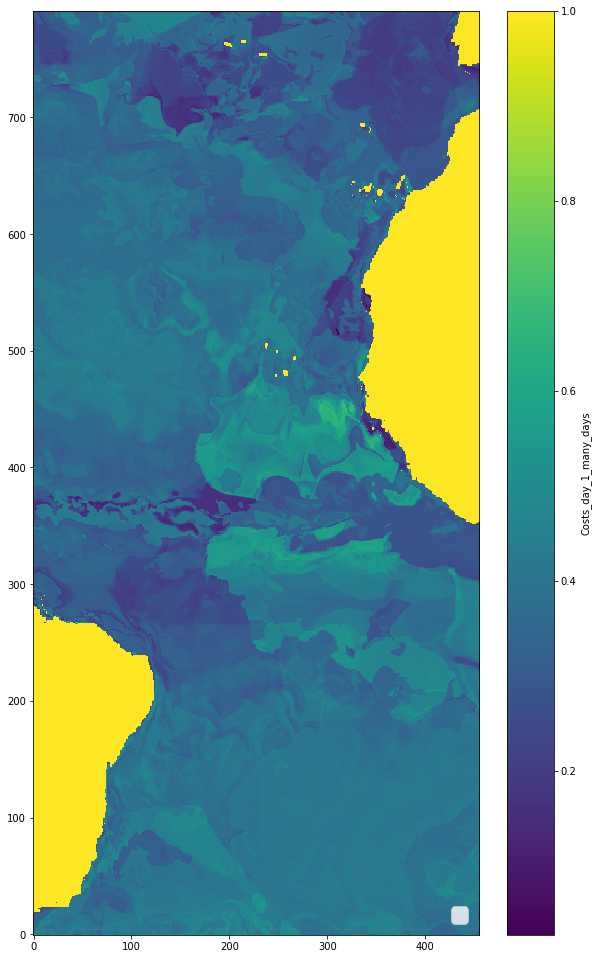

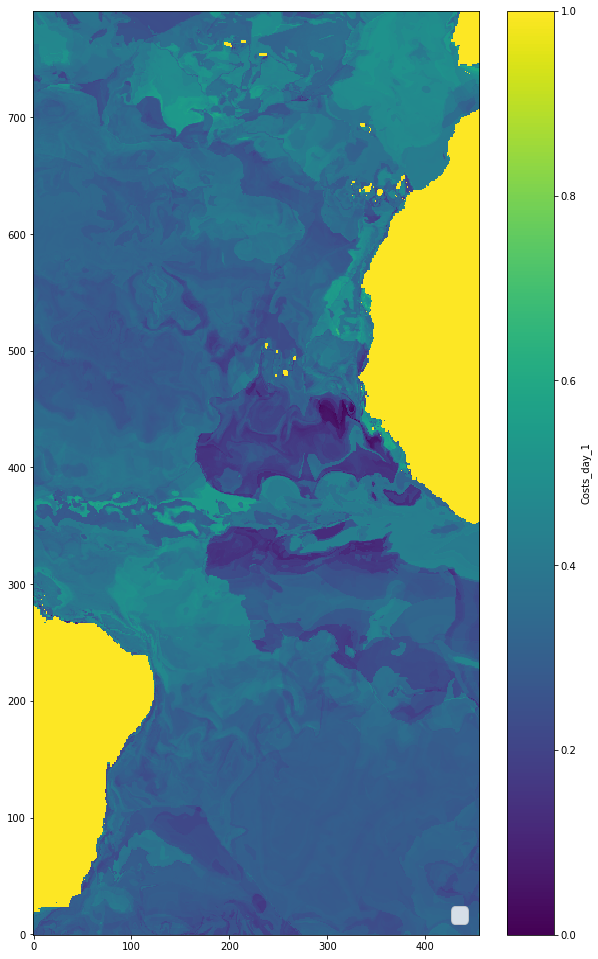

In [56]:
# Plot optimal route
plt.figure(figsize=(10,17))

# Costs
plt.imshow(costs_day_1, aspect='auto')

plt.colorbar(label = 'Costs_day_1_many_days')
plt.legend(loc = 'lower right', prop={'size': 22})
plt.gca().invert_yaxis()

plt.figure(figsize=(10,17))

# Costs
plt.imshow(rf_speed, aspect='auto')

plt.colorbar(label = 'Costs_day_1')
plt.legend(loc = 'lower right', prop={'size': 22})
plt.gca().invert_yaxis()

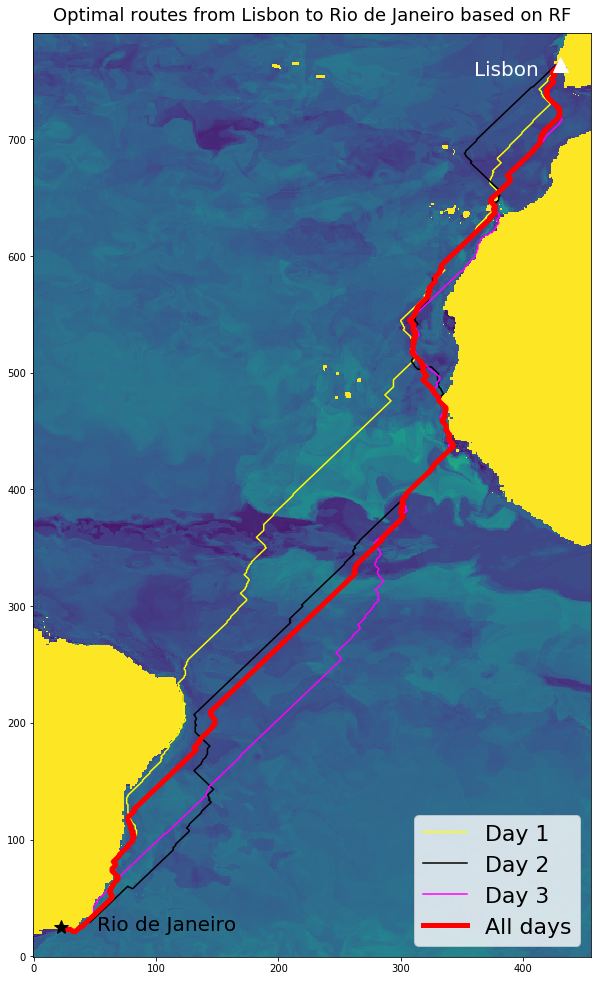

In [57]:
# Plot optimal route
plt.figure(figsize=(10,17))

# Costs
plt.imshow(costs_all_times_mean, aspect='auto')

# Routes
plt.plot(merged_indices_day_one[1], merged_indices_day_one[0], 'yellow', label = 'Day 1')
plt.plot(merged_indices_day_two[1], merged_indices_day_two[0], 'black', label = 'Day 2')
plt.plot(merged_indices_day_three[1], merged_indices_day_three[0], 'magenta', label = 'Day 3')
plt.plot(merged_indices_all_times[1], merged_indices_all_times[0], 'red', label = "All days", lw = 5)

# Start/end points
plt.plot(start_lon, start_lat, 'k^', markersize = 15, color = 'white')
plt.text(start_lon - 70, start_lat - 10, 'Lisbon', fontsize = 20, color = 'white')
plt.plot(end_lon, end_lat, 'k*', markersize = 15)
plt.text(end_lon + 30, end_lat - 3, 'Rio de Janeiro', fontsize = 20)
plt.title('Optimal routes from Lisbon to Rio de Janeiro based on RF', fontsize = 18, pad = 12)
# plt.colorbar(label = 'Inverted speed over ground all days')
plt.legend(loc = 'lower right', prop={'size': 22})
plt.gca().invert_yaxis()

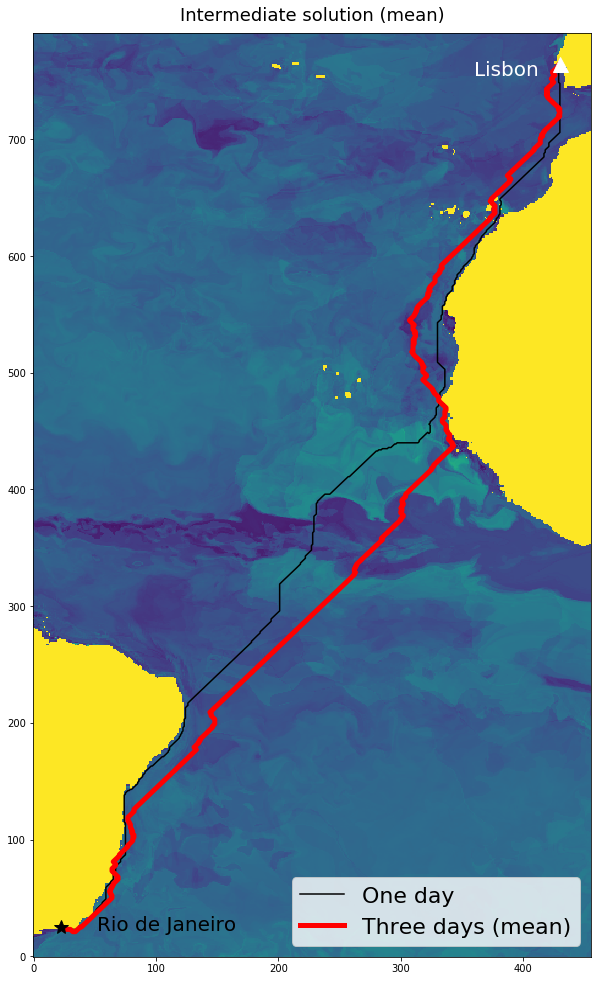

In [58]:
# Presentation plot intermediate solution
# Plot optimal route
plt.figure(figsize=(10,17))

# Costs
plt.imshow(costs_all_times_mean, aspect='auto')

# Routes
plt.plot(rf_indices[1], rf_indices[0], 'black', label = 'One day')
plt.plot(merged_indices_all_times[1], merged_indices_all_times[0], 'red', label = "Three days (mean)", lw = 5)

# Start/end points
plt.plot(start_lon, start_lat, 'k^', markersize = 15, color = 'white')
plt.text(start_lon - 70, start_lat - 10, 'Lisbon', fontsize = 20, color = 'white')
plt.plot(end_lon, end_lat, 'k*', markersize = 15)
plt.text(end_lon + 30, end_lat - 3, 'Rio de Janeiro', fontsize = 20)
plt.title('Intermediate solution (mean)', fontsize = 18, pad = 12)
#plt.colorbar(label = 'Inverted speed over ground all days')
plt.legend(loc = 'lower right', prop={'size': 22})
plt.gca().invert_yaxis()

## Advanced solution (costs separated)

In [59]:
# Find indices that can be reached within one day
# @see: https://stackoverflow.com/questions/52920499/find-all-points-within-distance-1-of-specific-point-in-2d-numpy-matrix
# Set up matrix
day_all_mask = np.zeros(map_shape)

# Convert to python scalars
r = start[0]
c = start[1]
# Get boundaries of array
m, n = day_all_mask.shape

# Set this value to a distance that the ship can reach within one day
dist_per_day = 300

# Loop over possible locations
for i in range(0-r,m): 
    for j in range(0-c,n): 
        # Check if location is within boundary
        if (0 <= r + i < m and 0 <= c + j < n):
            if np.linalg.norm([r+i,c+j] - np.array(start))<dist_per_day:
                day_all_mask[r+i,c+j] = 1
            elif (np.linalg.norm([r+i,c+j] - np.array(start))>=dist_per_day and 
                  np.linalg.norm([r+i,c+j] - np.array(start))<2*dist_per_day):
                day_all_mask[r+i,c+j] = 2
            else:
                day_all_mask[r+i,c+j] = 3

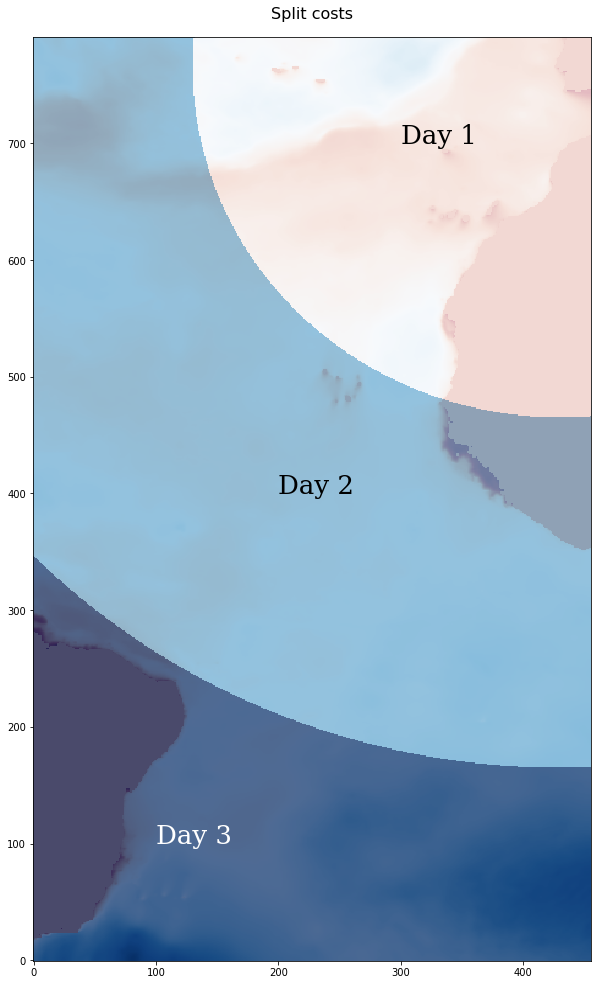

In [60]:
# Plot cost splitting
plt.figure(figsize=(10,17))

plt.text(300, 700, 'Day 1', color = 'black', fontfamily = 'serif', fontsize = 26)
plt.text(200, 400, 'Day 2', color = 'black', fontfamily = 'serif', fontsize = 26)
plt.text(100, 100, 'Day 3', color = 'white', fontfamily = 'serif', fontsize = 26)

# Costs
plt.imshow(day_all_mask, aspect = 'auto',cmap="Blues")
plt.imshow(land_mask, aspect='auto', cmap = 'RdBu', alpha=0.3)
plt.title('Split costs', fontsize = 16, pad = 18)
plt.gca().invert_yaxis()
plt.show()

In [61]:
costs_ecd = np.zeros(map_shape)

In [62]:
costs_ecd[day_all_mask == 1] = costs[0][day_all_mask == 1]
costs_ecd[day_all_mask == 2] = costs[1][day_all_mask == 2]
costs_ecd[day_all_mask == 3] = costs[2][day_all_mask == 3]

In [63]:
# Calculate optimal route for all days
indices_ecd_costs, weight_ecd = route_through_array(costs_ecd, start, end, fully_connected=True, geometric=False)
indices_ecd_costs = np.stack(indices_ecd_costs, axis=-1)

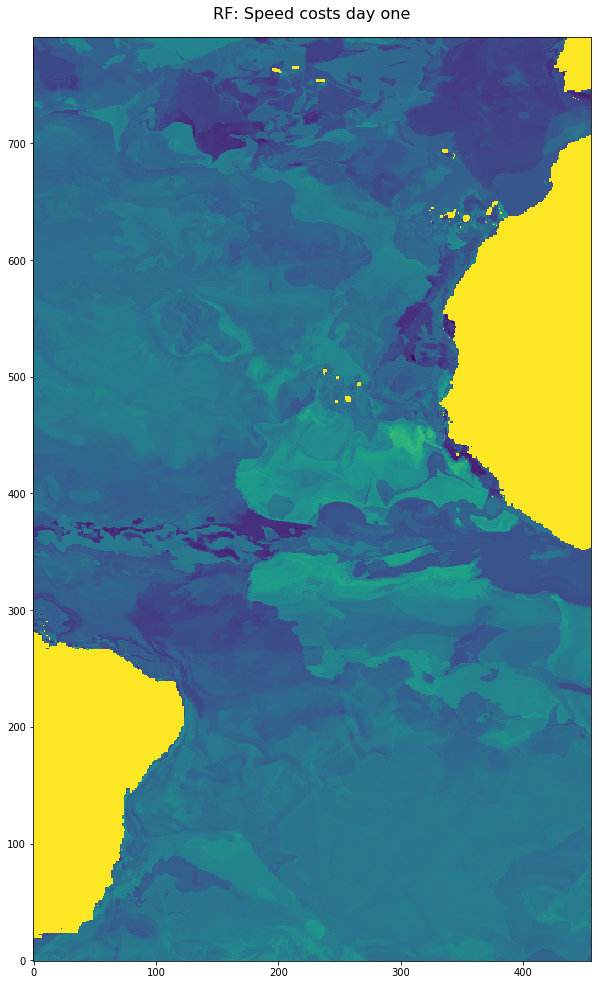

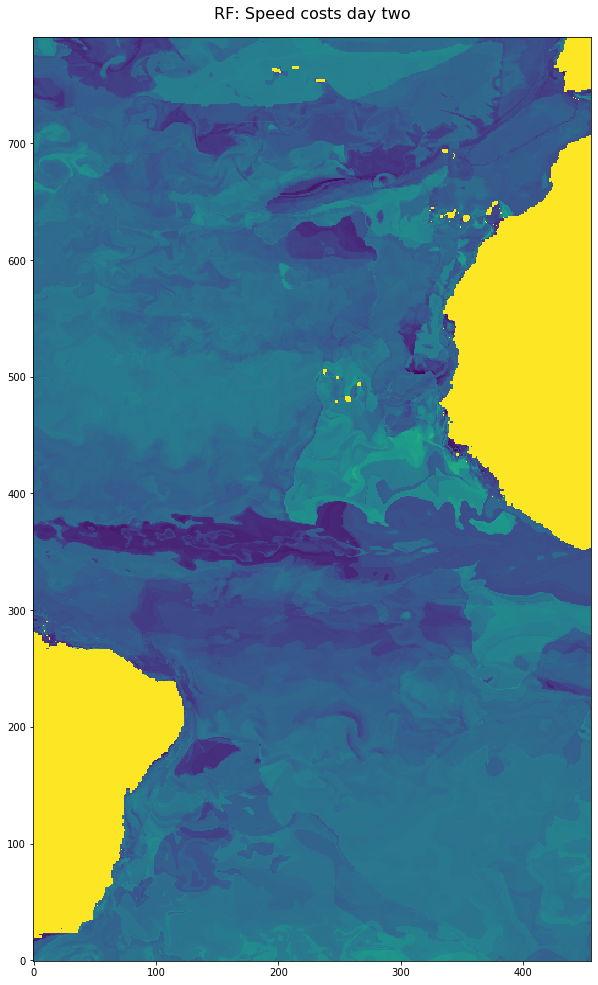

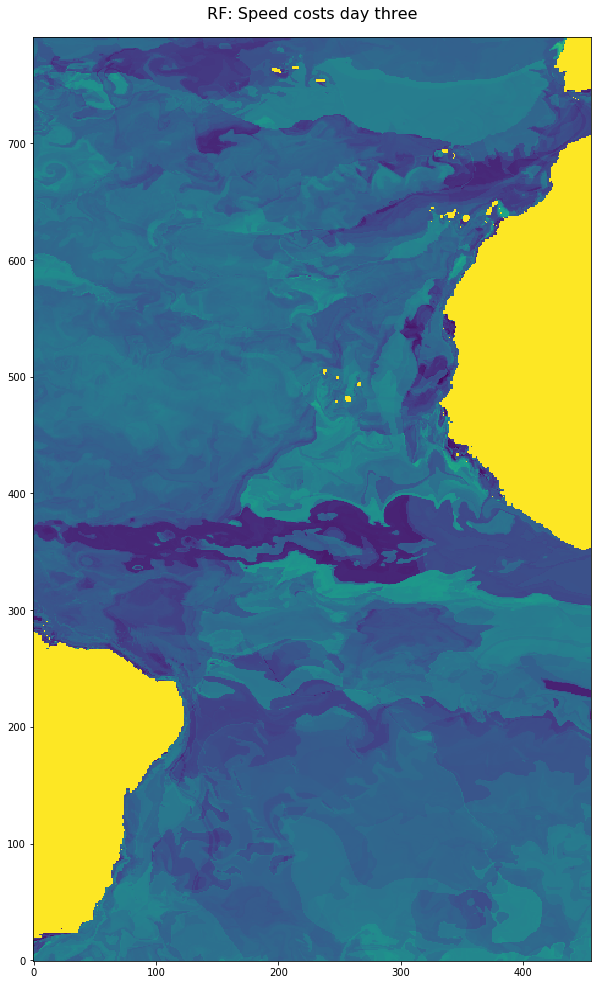

In [64]:
# Plot optimal route
plt.figure(figsize=(10,17))

# Costs
plt.imshow(costs[0], aspect='auto')
plt.title("RF: Speed costs day one", fontsize = 16, pad = 18)
plt.gca().invert_yaxis()

plt.figure(figsize=(10,17))
plt.imshow(costs[1], aspect='auto')
plt.title("RF: Speed costs day two", fontsize = 16, pad = 18)
plt.gca().invert_yaxis()

plt.figure(figsize=(10,17))
plt.imshow(costs[2], aspect='auto')
plt.title("RF: Speed costs day three", fontsize = 16, pad = 18)
plt.gca().invert_yaxis()

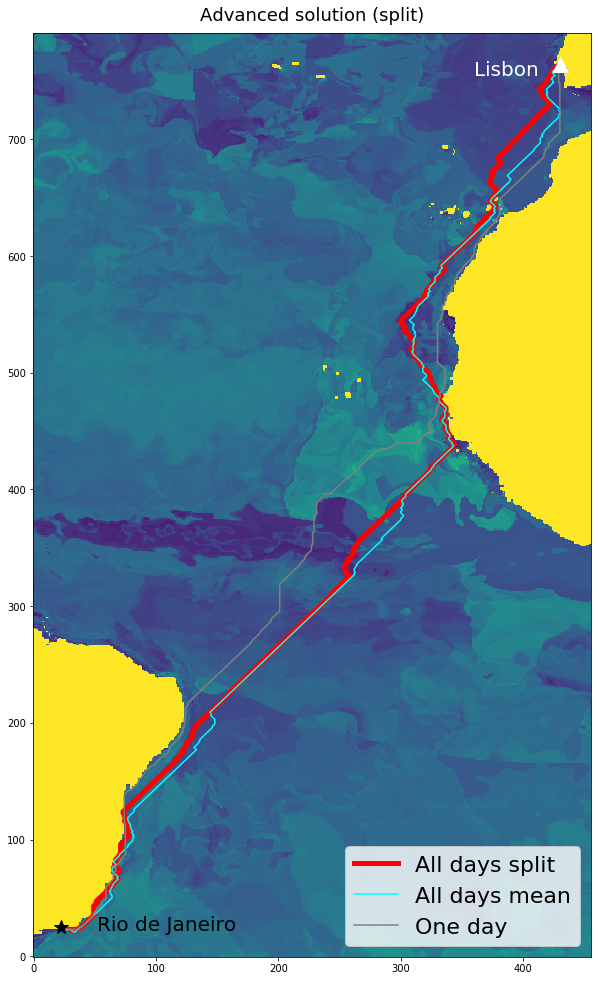

In [69]:
# Plot optimal route
plt.figure(figsize=(10,17))

# Costs
plt.imshow(costs_ecd, aspect='auto')

plt.plot(indices_ecd_costs[1],indices_ecd_costs[0], 'red', label = 'All days split', lw = 5)
plt.plot(merged_indices_all_times[1], merged_indices_all_times[0], 'cyan', label = 'All days mean')
# plt.plot(merged_indices_day_one[1], merged_indices_day_one[0], 'black', label = 'One day')
plt.plot(rf_indices[1], rf_indices[0], 'grey', label = 'One day')

# Start/end points
plt.plot(start_lon, start_lat, 'k^', markersize = 15, color = 'white')
plt.text(start_lon - 70, start_lat - 10, 'Lisbon', fontsize = 20, color = 'white')
plt.plot(end_lon, end_lat, 'k*', markersize = 15)
plt.text(end_lon + 30, end_lat - 3, 'Rio de Janeiro', fontsize = 20)
plt.title('Advanced solution (split)', fontsize = 18, pad = 12)
plt.legend(loc = 'lower right', prop={'size': 22})
#plt.colorbar(label = 'Inverted speed over ground')
plt.gca().invert_yaxis()

In [66]:
## Compute total costs
# Just one day (day 1)
print("Linear regression (One day)", weight_lr)

print("One day Simple solution: ", weight_simple_day_one)

print("One day: ", weight_day_one)
# Mean of all days
print("All days mean: ", weight_all_times)
# Multiple days 
print("All days splitted: ", weight_ecd)

# Relative to each other weight_day_one = 1
print("Costs relative to one day (simple solution)",weight_lr/weight_day_one)
# Just one day (day 1)
print("One day Simple solution: ", weight_simple_day_one/weight_day_one)

print("One day: ", weight_day_one/weight_day_one)
# Mean of all days
print("All days mean: ", weight_all_times/weight_day_one)
# Multiple days 
print("All days splitted: ", weight_ecd/weight_day_one)

Linear regression (One day) 96.69037938009586
One day Simple solution:  269.3991763584538
One day:  223.32171806886632
All days mean:  229.23686072353337
All days splitted:  205.6566625124047
Costs relative to one day (simple solution) 0.4329645151228829
One day Simple solution:  1.2063277082409802
One day:  1.0
All days mean:  1.0264870909368653
All days splitted:  0.9208986223587344


# Cost comparison (rounded)

| One day (LR) | One day (RF)| All days mean (RF)| All days splitted (RF)|
| ----------- | ----------- | ----------- | ----------- |
| X | 1 | 1.02 | 0.95 |


-> 5% faster splitting the route costs instead of using just one day

### References
* https://levelup.gitconnected.com/dijkstras-shortest-path-algorithm-in-a-grid-eb505eb3a290
* https://gist.github.com/mdsrosa/c71339cb23b <-- (Page not found..)